# Sections of the notebook:
- calculate 2020 anomalies in observation and model data (all months)

    - select smg.siberia, months 1-12
    - use smg.calculate_detrended stats, calculate anom, anom_detrend
    - select 2020 from the aforementioned variables
    - average over all months

    this returns spatially averaged, time-averaged statistics for siberia


- calculate 2020 anomalies in observation and model data (january-june)

    - select smg.siberia, months **1-6**
    - use smg.calculate_detrended stats, calculate anom, anom_detrend
    - select 2020 from the aforementioned variables
    - average over all months

    this returns spatially averaged, time-averaged heatwave statistics 


- calculate monthly temperature anomalies for observational and model

    open every model member
    calculate the anomaly and detrended anomaly

    this gives you the anomalies for every...


- model bias histogram

    - slice jan-jun, siberian region
    - take yearly average
    - take spatial average

    basically take a year-by-year average of the januaryjune period from all datasets. this is to qualitatively compare the spread of the yearly jan-jun 2-m temperature.


- make a pdf

    eventually use student's t-test for bias in the model mean (a systematic bias). needs absolute temperature data (no clim or anom), spatially averaged, yearly-averaged.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy
import matplotlib as mpl
from scipy import signal
import stats_mca_gemini as smg

from matplotlib import pyplot as plt
from scipy import stats

In [2]:
import datetime
from dateutil.relativedelta import relativedelta

def year_fraction_to_datetime(year_fraction):
    """Converts a year fraction to a datetime object."""

    year = int(year_fraction)
    fractional_year = year_fraction - year

    base_date = datetime.datetime(year, 1, 1)
    delta_days = int(fractional_year * 365)  # Approximate days in a year
    return base_date + relativedelta(days=delta_days)


def convert_year_fraction_to_datetime(year_fraction):
    year = int(year_fraction)
    remainder = year_fraction - year
    start_of_year = datetime(year, 1, 1)
    year_length = (datetime(year + 1, 1, 1) - start_of_year).days
    date = start_of_year + timedelta(days=remainder * year_length)
    return date

In [3]:
def create_pdf(arr):
    #'arr' is your NumPy array with temperature
    arr_kde = stats.gaussian_kde(arr) 
    # Create a range of values to evaluate the PDF on 
    x_vals = np.linspace(245, 275, 1000) 
    arr_pdf = arr_kde(x_vals)
    
    return arr_pdf, x_vals

# Calculate 2020 anomalies in observational and model data (all months)

In [4]:
## OBSERVATIONAL
# With Linear trend (all Steps)
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":12,
    "var":'t2m'
    }

# ERA5
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_temperature.nc"
ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})

era5_anom, _, era5_anomdetrend, _, _= smg.calculate_detrended_stats(ds, **kwargs)
era5_2020anom = era5_anom.sel(time="2020").mean()
era5_2020anomdetrend = era5_anomdetrend.sel(time="2020").mean()
ds.close()

# berkeley earth
path = "/data0/yvu/BerkeleyEarth/"
file = "Land_and_Ocean_LatLong1.nc"
ds = xr.open_dataset(path+file)

# convert time array to datetime
datetime_list = []
for i, date in enumerate(ds.time.values):
    datetime_list.append(year_fraction_to_datetime(date))
ds['time'] = datetime_list
ds=ds.sel(time=slice("1980","2024"))
ds['t2m'] = ds.temperature.groupby("time.month")+ds.climatology.rename({'month_number': 'month'})
berkeley_anom, _, berkeley_anomdetrend, _, _ = smg.calculate_detrended_stats(ds, **kwargs)
berkeley_2020anom = berkeley_anom.sel(time="2020").mean()
berkeley_2020anomdetrend = berkeley_anomdetrend.sel(time="2020").mean()
ds.close()

# NCEP
# path = "../../data0/yvu/NCEP/"
# file = "air.2m.mon.mean.nc"
# ds = xr.open_dataset(path+file)

# weights = np.cos(np.deg2rad(ds.lat))
# weights.name = "weights"

# ds = ds.air.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
# ds = ds.isel(time=ds.time.dt.month.isin(np.arange(month_start,month_end+1)))
# ds = ds.drop_vars("level")
# gb = ds.groupby('time.month')
# clim = gb.mean(dim='time')
# anom = gb - clim


# ncep_anom = anom.weighted(weights).mean(dim=('lon', 'lat'))
# ncep_anom = ncep_anom.drop_vars("month")
# ncep_2020anom = ncep_anom.sel(time="2020").mean()

# nan_ind = np.isnan(ncep_anom.values)

# ncep_anomdetrend = xr.where(np.isnan(ncep_anom.values), 1000, ncep_anom.values) # fill nan with 1000
# ncep_anomdetrend = signal.detrend(ncep_anomdetrend, axis=0, type='linear') # return detrended data in ndarray
# ncep_anomdetrend[nan_ind] = np.nan

# ncep_anomdetrend = xr.DataArray(ncep_anomdetrend, dims=['time'],
#                            coords={'time': anom.time})

# MERRA-2
path = '../../data0/yvu/MERRA-2/temperature/' 
file = "merged-M2TMNXSLV.nc4"# just 2-m temperature
ds = xr.open_dataset(path+file).sortby('time')

kwargs['var'] = 'T2M'
merra2_anom, _, merra2_anomdetrend, _, _ = smg.calculate_detrended_stats(ds, **kwargs)
merra2_2020anom = merra2_anom.sel(time="2020").mean()
merra2_2020anomdetrend = merra2_anomdetrend.sel(time="2020").mean()
ds.close()

print("\nThe ERA5 anomaly for 2020 is: ",era5_2020anom.round(3).values)
print("The Berkeley Earth anomaly for 2020 is: ",berkeley_2020anom.round(3).values)
print("The MERRA-2 anomaly for 2020 is: ",merra2_2020anom.round(3).values)
# print("The NCEP anomaly for 2020 is: ",ncep_2020anom.round(3).values)

## OBSERVATIONAL DETRENDED
print("\nThe detrended ERA5 anomaly for 2020 is: ",era5_2020anomdetrend.round(3).values)
print("The detrended Berkeley Earth anomaly for 2020 is: ",berkeley_2020anomdetrend.round(3).values)
print("The detrended MERRA-2 anomaly for 2020 is: ",merra2_2020anomdetrend.round(3).values)

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.

The ERA5 anomaly for 2020 is:  3.387
The Berkeley Earth anomaly for 2020 is:  2.77
The MERRA-2 anomaly for 2020 is:  2.145

The detrended ERA5 anomaly for 2020 is:  2.344
The detrended Berkeley Earth anomaly for 2020 is:  2.095
The detrended MERRA-2 anomaly for 2020 is:  1.734


In [5]:
### MODEL
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":12,
    "var":'tas'
    }

## ECHAM5
path = "../../data0/yvu/Results/"
model_string = "tas_ECHAM5_amip_obs_rf_ens"
ensemble_members = np.arange(1,51)
ensemble_members = [str(member).zfill(2) for member in ensemble_members] # convert member # to string with leading zero
file_type = ".nc"

# calculate and store anoms
echam_anom = np.zeros(50) # rows are ensemble members
echam_detrendanom = np.zeros(50) 
for i, member in enumerate(ensemble_members):
    file = model_string + member + file_type
    ds = xr.open_dataset(path+file)
    anom, _, detrend, _, _ = smg.calculate_detrended_stats(ds, **kwargs)
    echam_anom[i] = anom.sel(time="2020").mean()
    echam_detrendanom[i] = detrend.sel(time="2020").mean()
    ds.close()

## GFSv3
path = "../../data0/yvu/Results/"
model_string = "tas_GFSFV3_amip_obs_rf_ens"
ensemble_members = np.arange(1,100)
ensemble_members = [str(member).zfill(2) for member in ensemble_members] # convert member # to string with leading zero
file_type = ".nc"

# calculate and store anoms
gfs_detrendanom = np.zeros(99)
gfs_anom = np.zeros(99)
for i, member in enumerate(ensemble_members):
    file = model_string + member + file_type
    ds = xr.open_dataset(path+file)
    anom, _, detrend, _, _ = smg.calculate_detrended_stats(ds, **kwargs)
    gfs_anom[i] = anom.sel(time="2020").mean()
    gfs_detrendanom[i] = detrend.sel(time="2020").mean()
    ds.close()

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
Slicing data for the 'Sib

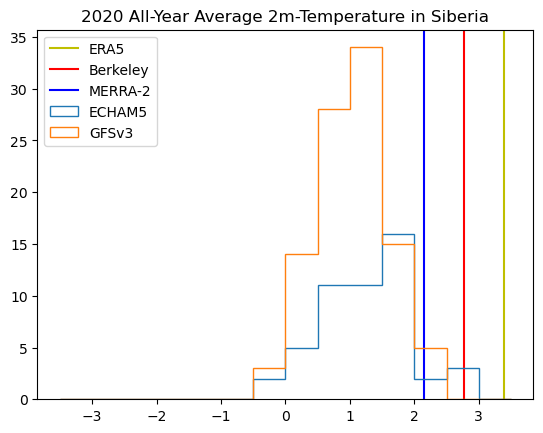

In [6]:
bin_edges = np.arange(-3.5, 4.0, 0.5) 
plt.axvline(era5_2020anom,color='y',label='ERA5')
plt.axvline(berkeley_2020anom,color='r',label='Berkeley')
plt.axvline(merra2_2020anom,color='b',label='MERRA-2')
plt.hist(np.ravel(echam_anom),histtype='step',label="ECHAM5",bins=bin_edges)
plt.hist(np.ravel(gfs_anom),histtype='step',label="GFSv3",bins=bin_edges)
plt.title("2020 All-Year Average 2m-Temperature in Siberia")
plt.legend()

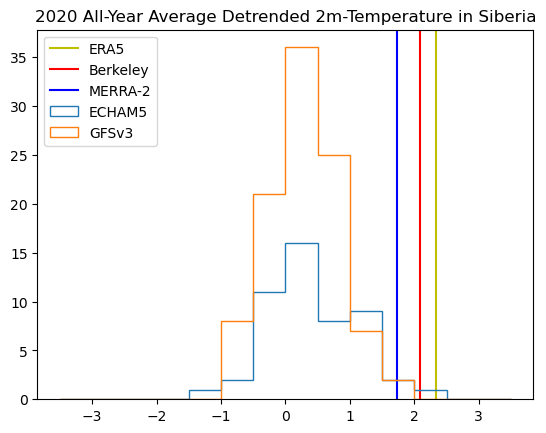

In [8]:
bin_edges = np.arange(-3.5, 4.0, 0.5) 
plt.axvline(era5_2020anomdetrend,color='y',label='ERA5')
plt.axvline(berkeley_2020anomdetrend,color='r',label='Berkeley')
plt.axvline(merra2_2020anomdetrend,color='b',label='MERRA-2')
plt.hist(np.ravel(echam_detrendanom),histtype='step',label="ECHAM5",bins=bin_edges)
plt.hist(np.ravel(gfs_detrendanom),histtype='step',label="GFSv3",bins=bin_edges)
plt.title("2020 All-Year Average Detrended 2m-Temperature in Siberia")
plt.legend()

# Calculate 2020 anomalies in observational and model data (Jan-Jun)

In [9]:
## OBSERVATIONAL
# With Linear trend (all Steps)
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":6,
    "var":'t2m'
    }

# ERA5
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_temperature.nc"
ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})

era5_anom, _, era5_anomdetrend, _, _ = smg.calculate_detrended_stats(ds, **kwargs)
era5_anom = era5_anom.sel(time="2020").mean()
era5_anomdetrend = era5_anomdetrend.sel(time="2020").mean()
ds.close()

# berkeley earth
path = "/data0/yvu/BerkeleyEarth/"
file = "Land_and_Ocean_LatLong1.nc"
ds = xr.open_dataset(path+file)

# convert time array to datetime
datetime_list = []
for i, date in enumerate(ds.time.values):
    datetime_list.append(year_fraction_to_datetime(date))
ds['time'] = datetime_list
ds=ds.sel(time=slice("1980","2024"))
ds['t2m'] = ds.temperature.groupby("time.month")+ds.climatology.rename({'month_number': 'month'})

berkeley_anom, _, berkeley_anomdetrend, _, _ = smg.calculate_detrended_stats(ds, **kwargs)
berkeley_anom = berkeley_anom.sel(time="2020").mean()
berkeley_anomdetrend = berkeley_anomdetrend.sel(time="2020").mean()
ds.close()

# NCEP
# path = "../../data0/yvu/NCEP/"
# file = "air.2m.mon.mean.nc"
# ds = xr.open_dataset(path+file)

# weights = np.cos(np.deg2rad(ds.lat))
# weights.name = "weights"

# ds = ds.air.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
# ds = ds.isel(time=ds.time.dt.month.isin(np.arange(month_start,month_end+1)))
# ds = ds.drop_vars("level")
# gb = ds.groupby('time.month')
# clim = gb.mean(dim='time')
# anom = gb - clim


# ncep_anom = anom.weighted(weights).mean(dim=('lon', 'lat'))
# ncep_anom = ncep_anom.drop_vars("month")
# ncep_anom = ncep_anom.sel(time="2020").mean()

# nan_ind = np.isnan(ncep_anom.values)

# ncep_anomdetrend = xr.where(np.isnan(ncep_anom.values), 1000, ncep_anom.values) # fill nan with 1000
# ncep_anomdetrend = signal.detrend(ncep_anomdetrend, axis=0, type='linear') # return detrended data in ndarray
# ncep_anomdetrend[nan_ind] = np.nan

# ncep_anomdetrend = xr.DataArray(ncep_anomdetrend, dims=['time'],
#                            coords={'time': anom.time})

# MERRA-2
path = '../../data0/yvu/MERRA-2/temperature/' 
file = "merged-M2TMNXSLV.nc4"# just 2-m temperature
ds = xr.open_dataset(path+file).sortby('time')

kwargs['var'] = 'T2M'
merra2_anom, _, merra2_anomdetrend, _, _ = smg.calculate_detrended_stats(ds, **kwargs)
merra2_anom = merra2_anom.sel(time="2020").mean()
merra2_anomdetrend = merra2_anomdetrend.sel(time="2020").mean()
ds.close()

print("\nThe ERA5 anomaly for 2020 is: ",era5_anom.round(3).values)
print("The Berkeley Earth anomaly for 2020 is: ",berkeley_anom.round(3).values)
print("The MERRA-2 anomaly for 2020 is: ",merra2_anom.round(3).values)
# print("The NCEP anomaly for 2020 is: ",ncep_anom.round(3).values)

## OBSERVATIONAL DETRENDED
print("\nThe detrended ERA5 anomaly for 2020 is: ",era5_anomdetrend.round(3).values)
print("The detrended Berkeley Earth anomaly for 2020 is: ",berkeley_anomdetrend.round(3).values)
print("The detrended MERRA-2 anomaly for 2020 is: ",merra2_anomdetrend.round(3).values)

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.

The ERA5 anomaly for 2020 is:  5.078
The Berkeley Earth anomaly for 2020 is:  4.251
The MERRA-2 anomaly for 2020 is:  3.608

The detrended ERA5 anomaly for 2020 is:  3.785
The detrended Berkeley Earth anomaly for 2020 is:  3.354
The detrended MERRA-2 anomaly for 2020 is:  3.038


In [10]:
### MODEL
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":6,
    "var":'tas'
    }

## ECHAM5
path = "../../data0/yvu/Results/"
model_string = "tas_ECHAM5_amip_obs_rf_ens"
ensemble_members = np.arange(1,51)
ensemble_members = [str(member).zfill(2) for member in ensemble_members] # convert member # to string with leading zero
file_type = ".nc"

# calculate and store anoms
echam_anom = np.zeros(50) # rows are ensemble members
echam_detrendanom = np.zeros(50) 
for i, member in enumerate(ensemble_members):
    file = model_string + member + file_type
    ds = xr.open_dataset(path+file)
    anom, _, detrend, _, _= smg.calculate_detrended_stats(ds, **kwargs)
    echam_anom[i] = anom.sel(time="2020").mean()
    echam_detrendanom[i] = detrend.sel(time="2020").mean()
    ds.close()

## GFSv3
path = "../../data0/yvu/Results/"
model_string = "tas_GFSFV3_amip_obs_rf_ens"
ensemble_members = np.arange(1,100)
ensemble_members = [str(member).zfill(2) for member in ensemble_members] # convert member # to string with leading zero
file_type = ".nc"

# calculate and store anoms
gfs_detrendanom = np.zeros(99)
gfs_anom = np.zeros(99)
for i, member in enumerate(ensemble_members):
    file = model_string + member + file_type
    ds = xr.open_dataset(path+file)
    anom, _, detrend, _, _ = smg.calculate_detrended_stats(ds, **kwargs)
    gfs_anom[i] = anom.sel(time="2020").mean()
    gfs_detrendanom[i] = detrend.sel(time="2020").mean()
    ds.close()

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.

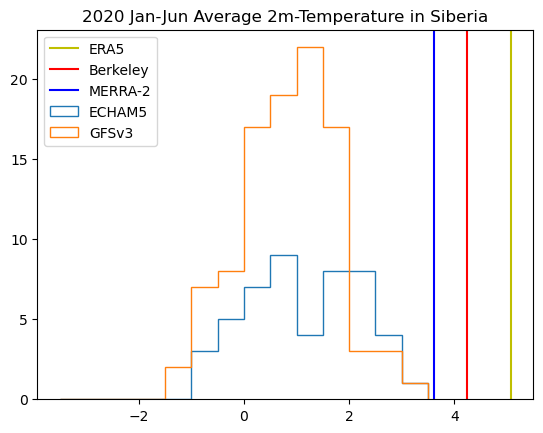

In [11]:
bin_edges = np.arange(-3.5, 4.0, 0.5) 
plt.axvline(era5_anom,color='y',label='ERA5')
plt.axvline(berkeley_anom,color='r',label='Berkeley')
plt.axvline(merra2_anom,color='b',label='MERRA-2')
plt.hist(np.ravel(echam_anom),histtype='step',label="ECHAM5",bins=bin_edges)
plt.hist(np.ravel(gfs_anom),histtype='step',label="GFSv3",bins=bin_edges)
plt.title("2020 Jan-Jun Average 2m-Temperature in Siberia")
plt.legend()

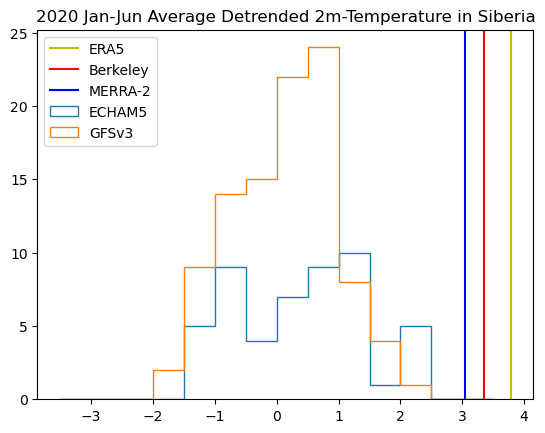

In [12]:
bin_edges = np.arange(-3.5, 4.0, 0.5) 
plt.axvline(era5_anomdetrend,color='y',label='ERA5')
plt.axvline(berkeley_anomdetrend,color='r',label='Berkeley')
plt.axvline(merra2_anomdetrend,color='b',label='MERRA-2')
plt.hist(np.ravel(echam_detrendanom),histtype='step',label="ECHAM5",bins=bin_edges)
plt.hist(np.ravel(gfs_detrendanom),histtype='step',label="GFSv3",bins=bin_edges)
plt.title("2020 Jan-Jun Average Detrended 2m-Temperature in Siberia")
plt.legend()

# histogram to look at the spread of 2-m temperature

In [13]:
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":6,
    "var":'t2m'
    }

# calculate ERA5 (observed) yearly avg
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_temperature.nc"

ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})
ds=ds[kwargs["var"]] # dropping the other variables makes this faster

weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"

ds_sub = smg.select_region_and_time(ds, kwargs["month_start"], kwargs["month_end"], region=kwargs["region"])
ds_sub=ds_sub.groupby('time.year').mean(dim='time')
era5_avg = ds_sub.weighted(weights).mean(dim=('longitude', 'latitude'))# latitude weighted mean

ds.close()
ds_sub.close()

# calculate Berekely Earth (observed) average
path = "/data0/yvu/BerkeleyEarth/"
file = "Land_and_Ocean_LatLong1.nc"
ds = xr.open_dataset(path+file)
# convert time array to datetime
datetime_list = []
for i, date in enumerate(ds.time.values):
    datetime_list.append(year_fraction_to_datetime(date))
ds['time'] = datetime_list
ds=ds.sel(time=slice("1980","2024"))

ds['temperature'] = ds.temperature.groupby("time.month")+ds.climatology.rename({'month_number': 'month'})
weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"

ds_sub = smg.select_region_and_time(ds.temperature, kwargs["month_start"], kwargs["month_end"], region=kwargs["region"])
ds_sub=ds_sub.groupby('time.year').mean(dim='time')
berkeley_avg = ds_sub.weighted(weights).mean(dim=('longitude', 'latitude'))# latitude weighted mean

ds.close()
ds_sub.close()

# calculate NCEP Renanalysis II (observed) average
path = "../../data0/yvu/NCEP/"
file = "air.2m.mon.mean.nc"

ds = xr.open_dataset(path+file)
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

ds_sub=smg.select_region_and_time(ds.air, kwargs["month_start"], kwargs["month_end"], region=kwargs["region"])
ds_sub=ds_sub.groupby('time.year').mean(dim='time')
ncep_avg = ds_sub.weighted(weights).mean(dim=('lon', 'lat'))# latitude weighted mean

ds.close()
ds_sub.close()

# calculate MERRA-2 average
path = '../../data0/yvu/MERRA-2/temperature/' 
file = "merged-M2TMNXSLV.nc4"# just 2-m temperature
ds = xr.open_dataset(path+file).sortby('time')

ds_sub=smg.select_region_and_time(ds.T2M, kwargs["month_start"], kwargs["month_end"], region=kwargs["region"])
weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"
ds_sub=ds_sub.groupby('time.year').mean(dim='time')
ds_sub=ds_sub.weighted(weights).mean(dim=('longitude', 'latitude'))
merra2_avg = ds_sub.compute()# latitude weighted mean

ds.close()
ds_sub.close()

## PLOTTING
plt.figure()
# bin_edges = np.arange(0, 4.5, 0.5) 
plt.hist(era5_avg-273.15,histtype='step',label='ERA5')#, bins=bin_edges)
plt.hist(berkeley_avg,histtype='step',label='Berkeley')
plt.hist(ncep_avg-273.15,histtype='step',label="NCEP")
plt.hist(merra2_avg-273.15,histtype='step',label='MERRA-2')
plt.xlabel("Temperature (C)")
plt.ylabel("Bin Counts")
plt.title("Histograms of Yearly Averaged Jan-Jun 2m Temperature")
plt.legend()
plt.show()

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.
Slicing data for the 'Siberia' region.
Filtering for months: 1 through 6.


ValueError: Dimensions ('lon',) not found in DataArrayWeighted dimensions ('level', 'year', 'lat', 'longitude', 'latitude')

In [ ]:
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":6,
    "var":'tas'
    }


# create ensemble member file path
path = "../../data0/yvu/Results/"
model_string = "tas_ECHAM5_amip_obs_rf_ens"
ensemble_members = np.arange(1,51)
ensemble_members = [str(member).zfill(2) for member in ensemble_members]
file_type = ".nc"

echam5_avg = np.zeros((50,43)) # rows are ensemble members, columns are years 1980-2023
for i, member in enumerate(ensemble_members):
    file = model_string + member + file_type
    ds = xr.open_dataset(path+file)

    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    
    ds_sub = smg.select_region_and_time(ds.tas, kwargs["month_start"], kwargs["month_end"], region=kwargs["region"])
    ds_sub=ds_sub.groupby('time.year').mean(dim='time')
    echam5_avg[i,:]=ds_sub.weighted(weights).mean(dim=('lon', 'lat'))# latitude weighted mean
    
    ds.close()
    ds_sub.close()

# same thing but for GFSv3
path = "../../data0/yvu/Results/"
model_string = "tas_GFSFV3_amip_obs_rf_ens"
ensemble_members = np.arange(1,100)
ensemble_members = [str(member).zfill(2) for member in ensemble_members] # convert member # to string with leading zero
file_type = ".nc"

gfsv3_avg = np.zeros((99,46)) # rows are ensemble members, columns are years 1980-202
for i, member in enumerate(ensemble_members):
    file = model_string+member+file_type
    ds = xr.open_dataset(path+file)

    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    ds_sub = smg.select_region_and_time(ds.tas, kwargs["month_start"], kwargs["month_end"], region=kwargs["region"])
    ds_sub=ds_sub.groupby('time.year').mean(dim='time')
    gfsv3_avg[i,:]=ds_sub.weighted(weights).mean(dim=('lon', 'lat'))# latitude weighted mean
    
    ds.close()
    ds_sub.close()

# bin_edges = np.arange(257, 264, 0.5) 
plt.hist(era5_avg,histtype='step',label='ERA5')#,bins=bin_edges)
plt.hist(np.ravel(echam5_avg),histtype='step',label="ECHAM5")#,bins=bin_edges)
plt.hist(np.ravel(gfsv3_avg),histtype='step',label="GFSv3")#,bins=bin_edges)
plt.legend()

In [ ]:
bin_edges = np.arange(257, 280, 0.5) 
plt.hist(era5_avg,histtype='step',label='ERA5',bins=bin_edges)
plt.hist(merra2_avg,histtype='step',label='MERRA-2',bins=bin_edges)
plt.show()

In [ ]:
# plt.hist(era5_avg,histtype='step',label='ERA5')#,bins=bin_edges)
plt.hist(np.ravel(echam5_avg),histtype='step',color='g',label="ECHAM5",bins=bin_edges)
plt.hist(np.ravel(gfsv3_avg),histtype='step',color='orange',label="GFSv3",bins=bin_edges)
plt.legend()
plt.show()

# make a pdf

In [ ]:
era5_pdf, x1 = create_pdf(era5_avg)
berkeley_pdf, x2 = create_pdf(berkeley_avg)

echam5_pdf, x3 = create_pdf(np.ravel(echam5_anom))
gfsv3_pdf, x4 = create_pdf(np.ravel(gfsv3_anom))

########

plt.figure(figsize=(10, 6)) 
# Plot the PDF
plt.plot(x1, era5_pdf, label='ERA5') 
plt.plot(x1, berkeley_pdf, label='Berkeley Earth') 
# Plot PDFs for other climate models in the same way 
plt.plot(x1, echam5_pdf, label='ECHAM5') 
plt.plot(x1, gfsv3_pdf, label='GFSv3') 

plt.xlabel('Temperature Anomaly (°C)') 
plt.ylabel('Probability Density') 
plt.title('Distribution of Observed/Modeled Eurasian Yearly Temperature Anomalies (Trend Included)') 
plt.legend() 
plt.grid(True) 
plt.show() 

In [ ]:
# era5_detrendpdf, x1 = create_pdf(era5_detrendanom)
# berkeley_detrendpdf, x2 = create_pdf(berekely_detrendanom)
# echam5_detrendpdf, x3 = create_pdf(np.ravel(echam_detrendanom))
# gfsv3_detrendpdf, x4 = create_pdf(np.ravel(gfs_detrendanom))

era5_pdf, x1 = create_pdf(era5_avg)
berkeley_pdf, x2 = create_pdf(berkeley_avg+273.15)
echam5_pdf, x3 = create_pdf(np.ravel(echam5_avg))
gfsv3_pdf, x4 = create_pdf(np.ravel(gfsv3_avg))


########

plt.figure(figsize=(10, 6)) 

plt.plot(x1, era5_pdf, label='ERA5',color='tab:blue')
plt.plot(x1, berkeley_pdf, label='Berkeley Earth',color='tab:orange') 
# Plot PDFs for other climate models in the same way 
plt.plot(x1, echam5_pdf, label='ECHAM5',color='tab:red') 
plt.plot(x1, gfsv3_pdf, label='GFSv3',color='tab:green') 


# Plot the PDF
# plt.plot(x1, era5_detrendpdf,linestyle='--',color='tab:blue') 
# plt.plot(x2, berkeley_detrendpdf,linestyle='--',color='tab:orange') 
# # Plot PDFs for other climate models in the same way 
# plt.plot(x3, echam5_detrendpdf,linestyle='--',color='tab:red') 
# plt.plot(x4, gfsv3_detrendpdf,linestyle='--',color='tab:green') 

plt.xlabel('Temperature Anomaly (°C)') 
plt.ylabel('Probability Density') 
plt.title('PDFs of Eurasian (Jan-Jun) Temperature Anomalies (with linear trend = solid)') 
plt.legend() 
plt.grid(True) 
plt.show() 

# Test mean shift bias
See if the mean value of all temp values are different, can use student t-test

## Calculate yearly 2m-temperature averaged over Siberia, all 12 months

In [ ]:
# Observations -- yearly mean calculation
# Siberia
min_lat = 50
max_lat = 70
min_lon = 65
max_lon = 120

# choose date range for average calculation
month_start = 1
month_end = 12

# calculate ERA5 (observed) yearly avg
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_temperature.nc"

ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})
ds=ds.t2m # dropping the other variables makes this faster

weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"

ds_sub = ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
ds_sub = ds_sub.isel(time=ds_sub.time.dt.month.isin(np.arange(month_start,month_end+1)))
ds_sub = ds_sub.groupby('time.year').mean(dim='time')
era5_avg = ds_sub.weighted(weights).mean(dim=('longitude', 'latitude'))# latitude weighted mean

ds.close()
ds_sub.close()

# calculate Berekely Earth (observed) average
path = "/data0/yvu/BerkeleyEarth/"
file = "Land_and_Ocean_LatLong1.nc"
ds = xr.open_dataset(path+file)
# convert time array to datetime
datetime_list = []
for i, date in enumerate(ds.time.values):
    datetime_list.append(year_fraction_to_datetime(date))
ds['time'] = datetime_list
ds=ds.sel(time=slice("1980","2024"))

ds['temperature'] = ds.temperature.groupby("time.month")+ds.climatology.rename({'month_number': 'month'})
weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"

ds_sub = ds.temperature.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))
ds_sub = ds_sub.isel(time=ds_sub.time.dt.month.isin(np.arange(month_start,month_end+1)))
ds_sub=ds_sub.groupby('time.year').mean(dim='time')
berkeley_avg = ds_sub.weighted(weights).mean(dim=('longitude', 'latitude'))# latitude weighted mean

ds.close()
ds_sub.close()

# calculate NCEP Renanalysis II (observed) average
path = "../../data0/yvu/NCEP/"
file = "air.2m.mon.mean.nc"

ds = xr.open_dataset(path+file)
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

ds_sub = ds.air.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
ds_sub = ds_sub.isel(time=ds_sub.time.dt.month.isin(np.arange(month_start,month_end+1)))
ds_sub=ds_sub.groupby('time.year').mean(dim='time')
ncep_avg = ds_sub.weighted(weights).mean(dim=('lon', 'lat'))# latitude weighted mean

ds.close()
ds_sub.close()

## PLOTTING
plt.figure()
# bin_edges = np.arange(0, 4.5, 0.5) 
plt.hist(era5_avg-273.15,histtype='step',label='ERA5')#, bins=bin_edges)
plt.hist(berkeley_avg,histtype='step',label='Berkeley')
plt.hist(ncep_avg-273.15,histtype='step',label="NCEP")
plt.xlabel("Temperature (C)")
plt.ylabel("Bin Counts")
plt.title("Histograms of Yearly Averaged Jan-Dec 2m Temperature Over Siberia")
plt.legend()
plt.show()

In [ ]:
# Model -- yearly mean calculation
# Siberia
min_lat = 50
max_lat = 70
min_lon = 65
max_lon = 120

# choose date range for average calculation
month_start = 1
month_end = 12

# create ensemble member file path
path = "../../data0/yvu/Results/"
model_string = "tas_ECHAM5_amip_obs_rf_ens"
ensemble_members = np.arange(1,51)
ensemble_members = [str(member).zfill(2) for member in ensemble_members]
file_type = ".nc"

echam5_avg = np.zeros((50,43)) # rows are ensemble members, columns are years 1980-2023
for i, member in enumerate(ensemble_members):
    file = model_string + member + file_type
    ds = xr.open_dataset(path+file)

    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    ds_sub = ds.tas.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon)) # change order of lat slice
    ds_sub = ds_sub.isel(time=ds_sub.time.dt.month.isin(np.arange(month_start,month_end+1)))
    ds_sub=ds_sub.groupby('time.year').mean(dim='time')
    echam5_avg[i,:]=ds_sub.weighted(weights).mean(dim=('lon', 'lat'))# latitude weighted mean
    
    ds.close()
    ds_sub.close()

# same thing but for GFSv3
path = "../../data0/yvu/Results/"
model_string = "tas_GFSFV3_amip_obs_rf_ens"
ensemble_members = np.arange(1,100)
ensemble_members = [str(member).zfill(2) for member in ensemble_members] # convert member # to string with leading zero
file_type = ".nc"

gfsv3_avg = np.zeros((99,46)) # rows are ensemble members, columns are years 1980-202
for i, member in enumerate(ensemble_members):
    file = model_string+member+file_type
    ds = xr.open_dataset(path+file)

    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    ds_sub = ds.tas.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon)) # change order of lat slice
    ds_sub = ds_sub.isel(time=ds_sub.time.dt.month.isin(np.arange(month_start,month_end+1)))
    ds_sub=ds_sub.groupby('time.year').mean(dim='time')
    gfsv3_avg[i,:]=ds_sub.weighted(weights).mean(dim=('lon', 'lat'))# latitude weighted mean
    
    ds.close()
    ds_sub.close()

# bin_edges = np.arange(257, 264, 0.5) 
plt.hist(era5_avg,histtype='step',label='ERA5')#,bins=bin_edges)
plt.hist(np.ravel(echam5_avg),histtype='step',label="ECHAM5")#,bins=bin_edges)
plt.hist(np.ravel(gfsv3_avg),histtype='step',label="GFSv3")#,bins=bin_edges)
plt.legend()

In [ ]:
# Model/observations -- convert to Gaussian PDFs
era5_pdf, x1 = create_pdf(era5_avg)
berkeley_pdf, x2 = create_pdf(berkeley_avg+273.15)
echam5_pdf, x3 = create_pdf(np.ravel(echam5_avg))
gfsv3_pdf, x4 = create_pdf(np.ravel(gfsv3_avg))


########

plt.figure(figsize=(10, 6)) 

plt.plot(x1, era5_pdf, label='ERA5',color='tab:blue')
plt.plot(x2, berkeley_pdf, label='Berkeley Earth',color='tab:orange') 
# Plot PDFs for other climate models in the same way 
plt.plot(x3, echam5_pdf, label='ECHAM5',color='tab:red') 
plt.plot(x4, gfsv3_pdf, label='GFSv3',color='tab:green') 

plt.xlabel('Temperature Anomaly (°C)') 
plt.ylabel('Probability Density') 
plt.title('PDFs of Siberian Yearly (Jan-Dec) 2m-Temperature Anomalies') 
plt.legend() 
plt.grid(True) 
plt.show() 

In [ ]:
# Student t-test on PDFs
# Perform the independent t-test
t_statistic, p_value = stats.ttest_ind(era5_pdf, berkeley_pdf, equal_var=True) 
# Set equal_var=False for Welch's t-test if assuming unequal variances

print(f"Independent t-test:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference between group means.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")

In [ ]:
# Student t-test on PDFs
# Perform the independent t-test
t_statistic, p_value = stats.ttest_ind(era5_pdf, echam5_pdf, equal_var=True) 
# Set equal_var=False for Welch's t-test if assuming unequal variances

print(f"Independent t-test:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference between group means.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")

In [ ]:
# Student t-test on PDFs
# Perform the independent t-test
t_statistic, p_value = stats.ttest_ind(era5_pdf, gfsv3_pdf, equal_var=True) 
# Set equal_var=False for Welch's t-test if assuming unequal variances

print(f"Independent t-test:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference between group means.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")

## Calculate yearly 2m-temperature averaged over Siberia, from January to June

In [ ]:
# Observations -- yearly mean calculation
# Siberia
min_lat = 50
max_lat = 70
min_lon = 65
max_lon = 120

# choose date range for average calculation
month_start = 1
month_end = 6

# calculate ERA5 (observed) yearly avg
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_temperature.nc"

ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})
ds=ds.t2m # dropping the other variables makes this faster

weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"

ds_sub = ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
ds_sub = ds_sub.isel(time=ds_sub.time.dt.month.isin(np.arange(month_start,month_end+1)))
ds_sub = ds_sub.groupby('time.year').mean(dim='time')
era5_avg = ds_sub.weighted(weights).mean(dim=('longitude', 'latitude'))# latitude weighted mean

ds.close()
ds_sub.close()

# calculate Berekely Earth (observed) average
path = "/data0/yvu/BerkeleyEarth/"
file = "Land_and_Ocean_LatLong1.nc"
ds = xr.open_dataset(path+file)
# convert time array to datetime
datetime_list = []
for i, date in enumerate(ds.time.values):
    datetime_list.append(year_fraction_to_datetime(date))
ds['time'] = datetime_list
ds=ds.sel(time=slice("1980","2024"))

ds['temperature'] = ds.temperature.groupby("time.month")+ds.climatology.rename({'month_number': 'month'})
weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"

ds_sub = ds.temperature.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))
ds_sub = ds_sub.isel(time=ds_sub.time.dt.month.isin(np.arange(month_start,month_end+1)))
ds_sub=ds_sub.groupby('time.year').mean(dim='time')
berkeley_avg = ds_sub.weighted(weights).mean(dim=('longitude', 'latitude'))# latitude weighted mean

ds.close()
ds_sub.close()

# calculate NCEP Renanalysis II (observed) average
path = "../../data0/yvu/NCEP/"
file = "air.2m.mon.mean.nc"

ds = xr.open_dataset(path+file)
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

ds_sub = ds.air.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
ds_sub = ds_sub.isel(time=ds_sub.time.dt.month.isin(np.arange(month_start,month_end+1)))
ds_sub=ds_sub.groupby('time.year').mean(dim='time')
ncep_avg = ds_sub.weighted(weights).mean(dim=('lon', 'lat'))# latitude weighted mean

ds.close()
ds_sub.close()

## PLOTTING
plt.figure()
# bin_edges = np.arange(0, 4.5, 0.5) 
plt.hist(era5_avg-273.15,histtype='step',label='ERA5')#, bins=bin_edges)
plt.hist(berkeley_avg,histtype='step',label='Berkeley')
plt.hist(ncep_avg-273.15,histtype='step',label="NCEP")
plt.xlabel("Temperature (C)")
plt.ylabel("Bin Counts")
plt.title("Histograms of Yearly Averaged Jan-Jun 2m Temperature Over Siberia")
plt.legend()
plt.show()

In [ ]:
# Model -- yearly mean calculation
# Siberia
min_lat = 50
max_lat = 70
min_lon = 65
max_lon = 120

# choose date range for average calculation
month_start = 1
month_end = 6

# create ensemble member file path
path = "../../data0/yvu/Results/"
model_string = "tas_ECHAM5_amip_obs_rf_ens"
ensemble_members = np.arange(1,51)
ensemble_members = [str(member).zfill(2) for member in ensemble_members]
file_type = ".nc"

echam5_avg = np.zeros((50,43)) # rows are ensemble members, columns are years 1980-2023
for i, member in enumerate(ensemble_members):
    file = model_string + member + file_type
    ds = xr.open_dataset(path+file)

    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    ds_sub = ds.tas.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon)) # change order of lat slice
    ds_sub = ds_sub.isel(time=ds_sub.time.dt.month.isin(np.arange(month_start,month_end+1)))
    ds_sub=ds_sub.groupby('time.year').mean(dim='time')
    echam5_avg[i,:]=ds_sub.weighted(weights).mean(dim=('lon', 'lat'))# latitude weighted mean
    
    ds.close()
    ds_sub.close()

# same thing but for GFSv3
path = "../../data0/yvu/Results/"
model_string = "tas_GFSFV3_amip_obs_rf_ens"
ensemble_members = np.arange(1,100)
ensemble_members = [str(member).zfill(2) for member in ensemble_members] # convert member # to string with leading zero
file_type = ".nc"

gfsv3_avg = np.zeros((99,46)) # rows are ensemble members, columns are years 1980-202
for i, member in enumerate(ensemble_members):
    file = model_string+member+file_type
    ds = xr.open_dataset(path+file)

    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    ds_sub = ds.tas.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon)) # change order of lat slice
    ds_sub = ds_sub.isel(time=ds_sub.time.dt.month.isin(np.arange(month_start,month_end+1)))
    ds_sub=ds_sub.groupby('time.year').mean(dim='time')
    gfsv3_avg[i,:]=ds_sub.weighted(weights).mean(dim=('lon', 'lat'))# latitude weighted mean
    
    ds.close()
    ds_sub.close()

# bin_edges = np.arange(257, 264, 0.5) 
plt.hist(era5_avg,histtype='step',label='ERA5')#,bins=bin_edges)
plt.hist(np.ravel(echam5_avg),histtype='step',label="ECHAM5")#,bins=bin_edges)
plt.hist(np.ravel(gfsv3_avg),histtype='step',label="GFSv3")#,bins=bin_edges)
plt.legend()

In [ ]:
x1-x2

In [ ]:
# Model/observations -- convert to Gaussian PDFs
era5_pdf, x1 = create_pdf(era5_avg)
berkeley_pdf, x2 = create_pdf(berkeley_avg+273.15)
echam5_pdf, x3 = create_pdf(np.ravel(echam5_avg))
gfsv3_pdf, x4 = create_pdf(np.ravel(gfsv3_avg))


########

plt.figure(figsize=(10, 6)) 

plt.plot(x1, era5_pdf, label='ERA5',color='tab:blue')
plt.plot(x2, berkeley_pdf, label='Berkeley Earth',color='tab:orange') 
# Plot PDFs for other climate models in the same way 
plt.plot(x3, echam5_pdf, label='ECHAM5',color='tab:red') 
plt.plot(x4, gfsv3_pdf, label='GFSv3',color='tab:green') 

plt.axvline(x=np.mean(era5_avg), color='b', linestyle='--', linewidth=2)
plt.axvline(x=np.mean(berkeley_avg+273.15), color='tab:orange', linestyle='--', linewidth=2)
plt.axvline(x=np.mean(np.ravel(echam5_avg)), color='tab:red', linestyle='--', linewidth=2)
plt.axvline(x=np.mean(np.ravel(gfsv3_avg)), color='tab:green', linestyle='--', linewidth=2)

plt.xlabel('Temperature Anomaly (°C)') 
plt.ylabel('Probability Density') 
plt.title('PDFs of Siberian Yearly (Jan-Jun) 2m-Temperature Anomalies') 
plt.legend() 
plt.grid(True) 
plt.show() 

In [ ]:
# Student t-test on PDFs
# Perform the independent t-test
t_statistic, p_value = stats.ttest_ind(era5_pdf, berkeley_pdf, equal_var=True) 
# Set equal_var=False for Welch's t-test if assuming unequal variances

print(f"Independent t-test:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference between group means.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")

In [ ]:
# Student t-test on PDFs
# Perform the independent t-test
t_statistic, p_value = stats.ttest_ind(era5_pdf, echam5_pdf, equal_var=True) 
# Set equal_var=False for Welch's t-test if assuming unequal variances

print(f"Independent t-test:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference between group means.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")

In [ ]:
# Student t-test on PDFs
# Perform the independent t-test
t_statistic, p_value = stats.ttest_ind(era5_pdf, gfsv3_pdf, equal_var=True) 
# Set equal_var=False for Welch's t-test if assuming unequal variances

print(f"Independent t-test:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference between group means.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")

In [ ]:
# Student t-test on PDFs
# Perform the independent t-test
t_statistic, p_value = stats.ttest_ind(echam5_pdf, berkeley_pdf, equal_var=True) 
# Set equal_var=False for Welch's t-test if assuming unequal variances

print(f"Independent t-test:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference between group means.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")

In [ ]:
# Student t-test on PDFs
# Perform the independent t-test
t_statistic, p_value = stats.ttest_ind(berkeley_pdf, gfsv3_pdf, equal_var=True) 
# Set equal_var=False for Welch's t-test if assuming unequal variances

print(f"Independent t-test:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference between group means.")
else:
    print("Fail to reject the null hypothesis: No significant difference found.")

## Calculate yearly anomaly 2m-temperature averaged over Siberia, Jan-Jun

In [ ]:
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":6,
    "var":'t2m'
    }

# ERA5
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_temperature.nc"
ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})

era5_anom, _, era5_anomdetrend, _ = smg.calculate_detrended_stats(ds, **kwargs)
era5_anom = era5_anom.sel(time="2020").mean()
era5_anomdetrend = era5_anomdetrend.sel(time="2020").mean()
ds.close()

# berkeley earth
path = "/data0/yvu/BerkeleyEarth/"
file = "Land_and_Ocean_LatLong1.nc"
ds = xr.open_dataset(path+file)

# convert time array to datetime
datetime_list = []
for i, date in enumerate(ds.time.values):
    datetime_list.append(year_fraction_to_datetime(date))
ds['time'] = datetime_list
ds=ds.sel(time=slice("1980","2024"))
ds['t2m'] = ds.temperature.groupby("time.month")+ds.climatology.rename({'month_number': 'month'})

berkeley_anom, _, berkeley_anomdetrend, _ = smg.calculate_detrended_stats(ds, **kwargs)
berkeley_anom = berkeley_anom.sel(time="2020").mean()
berkeley_anomdetrend = berkeley_anomdetrend.sel(time="2020").mean()
ds.close()

In [ ]:
print("(ERA5) The 2020 anomaly over Eurasia is "+str(era5_anom.values))
print("(Berkeley) The 2020 anomaly over Eurasia is "+str(berkeley_anom.values))

In [ ]:
# kwargs={
#     "region":smg.siberia,
#     "month_start":1,
#     "month_end":6,
#     "var":'tas'
#     }

# # create ensemble member file path
# path = "../../data0/yvu/Results/"
# model_string = "tas_ECHAM5_amip_obs_rf_ens"
# ensemble_members = np.arange(1,51)
# ensemble_members = [str(member).zfill(2) for member in ensemble_members]
# file_type = ".nc"

# echam_2020anom = np.zeros((50,43))
# echam_anom = np.zeros((50,43))
# for i, member in enumerate(ensemble_members):
#     file = model_string + member + file_type
#     ds = xr.open_dataset(path+file)
#     _, echam_2020anom[i,:] = calcClimAnom_model(ds,min_lat,max_lat,min_lon,max_lon,month_start,month_end)
#     ds.close()

# # repeat process but with detrending enabled
# echam_detrend_2020anom = np.zeros((50,43))
# echam_detrend_anom = np.zeros((50,43))
# for i, member in enumerate(ensemble_members):
#     file = model_string + member + file_type
#     ds = xr.open_dataset(path+file)
#     echam_detrend_anom[i], echam_detrend_2020anom[i] = calcClimAnom_model(ds,min_lat,max_lat,min_lon,max_lon,month_start,month_end,detrend=True)
#     ds.close()

In [ ]:
### MODEL
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":6,
    "var":'tas'
    }

## ECHAM5
path = "../../data0/yvu/Results/"
model_string = "tas_ECHAM5_amip_obs_rf_ens"
ensemble_members = np.arange(1,51)
ensemble_members = [str(member).zfill(2) for member in ensemble_members] # convert member # to string with leading zero
file_type = ".nc"

# calculate and store anoms
echam_anom = np.zeros(50) # rows are ensemble members
echam_detrendanom = np.zeros(50) 
for i, member in enumerate(ensemble_members):
    file = model_string + member + file_type
    ds = xr.open_dataset(path+file)
    anom, _, detrend, _ = smg.calculate_detrended_stats(ds, **kwargs)
    echam_anom[i] = anom.sel(time="2020").mean()
    echam_detrendanom[i] = detrend.sel(time="2020").mean()
    ds.close()

## GFSv3
path = "../../data0/yvu/Results/"
model_string = "tas_GFSFV3_amip_obs_rf_ens"
ensemble_members = np.arange(1,100)
ensemble_members = [str(member).zfill(2) for member in ensemble_members] # convert member # to string with leading zero
file_type = ".nc"

# calculate and store anoms
gfs_detrendanom = np.zeros(99)
gfs_anom = np.zeros(99)
for i, member in enumerate(ensemble_members):
    file = model_string + member + file_type
    ds = xr.open_dataset(path+file)
    anom, _, detrend, _ = smg.calculate_detrended_stats(ds, **kwargs)
    gfs_anom[i] = anom.sel(time="2020").mean()
    gfs_detrendanom[i] = detrend.sel(time="2020").mean()
    ds.close()

In [ ]:
# specifying the plot size
plt.figure()
bin_edges = np.arange(0, 4.5, 0.5) 
plt.hist(echam_2020anom, bins=bin_edges)
plt.xlabel("Anomaly")
plt.ylabel("Bin Counts")
plt.title("ECHAM5 Ensemble Member Histogram of Jan-Jun 2020 Anomaly")
plt.axvline(x = era5_2020anom, color = '#785EF0', label = 'ERA5')
plt.axvline(x = berkeley_2020anom, color = '#FE6100', label = 'Berkeley')
plt.axvline(x = ncep_2020anom, color = '#FFB000', label = 'NCEP')
plt.legend()

# rendering plot
plt.show()

In [ ]:
# Model/observations -- convert to Gaussian PDFs
era5_pdf, x1 = create_pdf(era5_avg)
berkeley_pdf, x2 = create_pdf(berkeley_avg+273.15)
echam5_pdf, x3 = create_pdf(np.ravel(echam5_avg))
gfsv3_pdf, x4 = create_pdf(np.ravel(gfsv3_avg))


########

plt.figure(figsize=(10, 6)) 

plt.plot(x1, era5_pdf, label='ERA5',color='tab:blue')
plt.plot(x2, berkeley_pdf, label='Berkeley Earth',color='tab:orange') 
# Plot PDFs for other climate models in the same way 
plt.plot(x3, echam5_pdf, label='ECHAM5',color='tab:red') 
plt.plot(x4, gfsv3_pdf, label='GFSv3',color='tab:green') 

plt.xlabel('Temperature Anomaly (°C)') 
plt.ylabel('Probability Density') 
plt.title('PDFs of Siberian Yearly (Jan-Jun) 2m-Temperature Anomalies') 
plt.legend() 
plt.grid(True) 
plt.show() 

don't remove trend, look at yearly average, from 79-2024, plot histogram, convert pdf

This isn't the right statistical analysis so I'm not using this. I think it's because I don't really care about the shape but rather whether or not there's a mean shift bias or if the actual anomal falls within the range of 2020 anomalies of all model members

In [ ]:
ks_statistic, p_value = kstest(era5_avg, berkeley_avg)

print(f"K-S Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("The two datasets are from different distributions (reject H0)")
else:
    print("Cannot conclude the datasets are from different distributions (fail to reject H0)")

In [ ]:
import numpy as np
from scipy.stats import ks_2samp, kstest

# Assume you have your 1D NumPy arrays of temperature anomalies
# These should be flattened arrays of all your anomaly values
# Perform the two-sample K-S test
ks_statistic, p_value = kstest(era5_pdf, berkeley_pdf)

print(f"K-S Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("The two datasets are from different distributions (reject H0)")
else:
    print("Cannot conclude the datasets are from different distributions (fail to reject H0)")

In [ ]:
ks_statistic, p_value = ks_2samp(np.ravel(echam5_pdf), np.ravel(gfsv3_pdf))

print(f"K-S Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("The two datasets are from different distributions (reject H0)")
else:
    print("Cannot conclude the datasets are from different distributions (fail to reject H0)")

In [ ]:
ks_statistic, p_value = ks_2samp(era5_pdf, np.ravel(gfsv3_pdf))

print(f"K-S Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("The two datasets are from different distributions (reject H0)")
else:
    print("Cannot conclude the datasets are from different distributions (fail to reject H0)")

In [ ]:
ks_statistic, p_value = ks_2samp(era5_pdf, np.ravel(echam5_pdf))

print(f"K-S Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("The two datasets are from different distributions (reject H0)")
else:
    print("Cannot conclude the datasets are from different distributions (fail to reject H0)")